In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, cohen_kappa_score, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import VotingClassifier

import xgboost as xgb
import lightgbm as lgb

import optuna
from optuna import Trial
from tqdm.notebook import tqdm

from gensim.models.fasttext import load_facebook_model
import compress_fasttext
import fasttext
import fasttext.util

In [54]:
from nltk.corpus import stopwords

In [59]:
stops = set(stopwords.words('english'))
stops.remove("no")
stops.remove("not")

In [2]:
data =  pd.read_csv("data/features.csv")
labels = pd.read_csv("data/labels.csv")

# Reorder labels to match data order
data = pd.merge(data,labels)
labels = data["genre"]
data.drop(columns=["genre"], inplace=True)

n_classes = labels.unique().shape[0]

In [3]:
unused_features = ["trackID"]
tag_feature = ["tags"]
title_feature = ["title"]
categorical_features = ["key", "mode"]
numerical_features = data.columns[~data.columns.isin(categorical_features + tag_feature + 
                                                     unused_features+title_feature)]

# Preprocessing

TODO: <br>
 - Drop Unused Columns 
 - Impute/Drop Missing Values
 - Tags Embeding 
     - FastText good result but model too large, using compress technique big loss on the model performance
     - Doc2Vec not good 
     - Bag of words & Tf-Idf not good enough 
 - Scale Numerical Value
 - PCA 
     - After Few tries it reduces the performance of the model 
 - One Hot Encoding 

In [4]:
ft_model = compress_fasttext.models.CompressedFastTextKeyedVectors.load("mini_cc.en.300.bin")

In [62]:
def replace(X):
    return [s.replace(",", "").lower() for s in X]

In [63]:
def remove_stops(X):
    return [" ".join([word for word in s.split() if word not in stops]) for s in X]

In [64]:
text_pipeline = Pipeline([ 
    ("imputer", SimpleImputer(strategy="constant", fill_value="",)),
    ("reshape", FunctionTransformer(np.reshape, kw_args={"newshape":-1})),
    ("replace", FunctionTransformer(replace, validate=False)),
    ("stops", FunctionTransformer(remove_stops, validate=False)),
    ("tfids", TfidfVectorizer())
    #("fasttext", FunctionTransformer(lambda x: pd.DataFrame([g_ft.wv.get_vector(s) for s in tqdm(x)])))
])

In [65]:
numerical_pipeline = Pipeline([ 
    ("imputer", SimpleImputer(strategy="mean")),
    ("std_scaler", StandardScaler())
])

In [66]:
categorical_pipeline = Pipeline([ 
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("one_hot", OneHotEncoder())
])

In [67]:
preprocessing_pipeline = ColumnTransformer([
    ("numerical", numerical_pipeline, numerical_features),
    ("categorical", categorical_pipeline, categorical_features),
    ("tags", text_pipeline, tag_feature),
    ("titles", text_pipeline, title_feature)
])

# Training

In [68]:
def compute_metrics(y_true, y_pred):
    print(f"acc: {accuracy_score(y_true, y_pred)}")
    print(f"kappa: {cohen_kappa_score(y_pred, y_true)}")
          
    ConfusionMatrixDisplay.from_predictions(y_pred, y_val, 
                          display_labels=label_encoder.classes_, xticks_rotation="vertical")

In [69]:
def study_report(study):
    print("Number of finished trials: ", len(study.trials))
    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))
    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

In [70]:
X_train, X_test, y_train, y_test = train_test_split(data, labels,
                                                    stratify=labels.values.reshape(-1,1),
                                                    test_size=0.15, shuffle=True, random_state=42)
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,
                                                    stratify=y_train,
                                                    test_size=0.15, shuffle=True, random_state=42)

In [71]:
X_train = preprocessing_pipeline.fit_transform(X_train)
X_val = preprocessing_pipeline.transform(X_val)
X_test = preprocessing_pipeline.transform(X_test)

In [72]:
X_train.shape, y_train.shape

((5871, 10130), (5871,))

### XGB

In [15]:
def objective(trial, dtrain, evals, params):
    
    params["eta"] = trial.suggest_float("eta", 1e-8, 1.0, log=True)
    params["max_depth"] = trial.suggest_int("max_depth", 1, 9)
    params["min_child_weight"] = trial.suggest_int("min_child_weight", 2, 10)
    params["subsample"] = trial.suggest_float("subsample", 0.2, 1.0)
    params["colsample_bytree"] = trial.suggest_float("colsample_bytree", 0.2, 1.0)
    params["lambda"] = trial.suggest_float("lambda", 1e-8, 1.0, log=True)
    params["alpha"] = trial.suggest_float("alpha", 1e-8, 1.0, log=True)
    params["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)

    xgb_model = xgb.train(
        params=params,
        dtrain=dtrain,
        evals=evals,
        num_boost_round=2500,
        early_stopping_rounds=20,
        verbose_eval=100
    )    
    # xgb_model.best_score --> log loss
    y_pred = xgb_model.predict(dval).argmax(axis=1)
    return cohen_kappa_score(y_pred, y_v)

In [16]:
params = {
    "verbosity": 0,
    "objective": "multi:softprob",
    "eval_metric": "mlogloss",
    "num_class": n_classes
}

In [ ]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)

deval = [(dval, 'eval')] 

In [ ]:
xgb_study = optuna.create_study(direction="minimize")
study.optimize(lambda trial: objective(trial, dtrain, deval, params), n_trials=20, timeout=600)

In [ ]:
study_report(xgb_study)

In [ ]:
xgb_model = xgb.train(
    params={**params,**trial.params},
    dtrain=dtrain,
    evals=deval,
    num_boost_round=2500,
    early_stopping_rounds=50,
    verbose_eval=50
) 

In [ ]:
y_pred = xgb_model.predict(dval).argmax(axis=1)
compute_metrics(y_pred, y_val)

### LGB

In [73]:
def lgb_objective(trial, dtrain, dval, params):    
    param = {**params,
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
    }
    
    lgb_model = lgb.train(param, dtrain, valid_sets=[dval], num_boost_round=1000,
                    callbacks=[lgb.log_evaluation(50), lgb.early_stopping(25)]
               )

    return lgb_model.best_score["valid_0"]["multi_logloss"]

In [74]:
params = {
    "objective": "multiclass",
    "metric": "multi_logloss",
    "verbosity": -1,
    "boosting_type": "gbdt",
    "feature_pre_filter": False,
    "device" : "gpu",
    "num_class": n_classes
}

In [75]:
dtrain = lgb.Dataset(X_train,y_train)
dval = lgb.Dataset(X_val, y_val)

In [76]:
study = optuna.create_study(direction="minimize")
study.optimize(lambda trial: lgb_objective(trial, dtrain, dval, params), n_trials=100)

[I 2021-10-29 05:49:21,458] A new study created in memory with name: no-name-018cdd7e-9be4-4fe7-b654-5b6bf35e4c7f


Training until validation scores don't improve for 25 rounds
[50]	valid_0's multi_logloss: 0.956644


[I 2021-10-29 05:49:42,285] Trial 0 finished with value: 0.9530616511175344 and parameters: {'lambda_l1': 0.000936152368890218, 'lambda_l2': 0.01472536737303122, 'num_leaves': 210, 'feature_fraction': 0.5379659630913496, 'bagging_fraction': 0.7052450412809803, 'bagging_freq': 4, 'min_child_samples': 20}. Best is trial 0 with value: 0.9530616511175344.


Early stopping, best iteration is:
[40]	valid_0's multi_logloss: 0.953062
Training until validation scores don't improve for 25 rounds
[50]	valid_0's multi_logloss: 0.934514


[I 2021-10-29 05:50:00,071] Trial 1 finished with value: 0.9338573130108776 and parameters: {'lambda_l1': 0.00118721124245903, 'lambda_l2': 4.8454022067163615e-05, 'num_leaves': 221, 'feature_fraction': 0.48904663460111997, 'bagging_fraction': 0.5941341299796388, 'bagging_freq': 1, 'min_child_samples': 28}. Best is trial 1 with value: 0.9338573130108776.


Early stopping, best iteration is:
[51]	valid_0's multi_logloss: 0.933857
Training until validation scores don't improve for 25 rounds
[50]	valid_0's multi_logloss: 0.948987


[I 2021-10-29 05:50:15,738] Trial 2 finished with value: 0.9351413642470126 and parameters: {'lambda_l1': 0.0031711584534533685, 'lambda_l2': 0.09408253558134473, 'num_leaves': 67, 'feature_fraction': 0.7558713557328447, 'bagging_fraction': 0.5726992974890112, 'bagging_freq': 6, 'min_child_samples': 42}. Best is trial 1 with value: 0.9338573130108776.


Early stopping, best iteration is:
[69]	valid_0's multi_logloss: 0.935141
Training until validation scores don't improve for 25 rounds
[50]	valid_0's multi_logloss: 0.895325


[I 2021-10-29 05:50:33,981] Trial 3 finished with value: 0.8885333400794734 and parameters: {'lambda_l1': 8.274507157443615e-05, 'lambda_l2': 0.022489353697429697, 'num_leaves': 66, 'feature_fraction': 0.5934604909108429, 'bagging_fraction': 0.9320930845635601, 'bagging_freq': 2, 'min_child_samples': 56}. Best is trial 3 with value: 0.8885333400794734.


Early stopping, best iteration is:
[60]	valid_0's multi_logloss: 0.888533
Training until validation scores don't improve for 25 rounds
[50]	valid_0's multi_logloss: 0.932951
[100]	valid_0's multi_logloss: 0.876703


[I 2021-10-29 05:50:49,492] Trial 4 finished with value: 0.8742741825473539 and parameters: {'lambda_l1': 0.0014844588238680488, 'lambda_l2': 1.2547871528507133, 'num_leaves': 17, 'feature_fraction': 0.943438272335778, 'bagging_fraction': 0.9690601829028518, 'bagging_freq': 6, 'min_child_samples': 87}. Best is trial 4 with value: 0.8742741825473539.


Early stopping, best iteration is:
[119]	valid_0's multi_logloss: 0.874274
Training until validation scores don't improve for 25 rounds
[50]	valid_0's multi_logloss: 0.999468


[I 2021-10-29 05:51:25,022] Trial 5 finished with value: 0.9977559319045867 and parameters: {'lambda_l1': 5.618222097221123e-06, 'lambda_l2': 0.42959514244444863, 'num_leaves': 198, 'feature_fraction': 0.8565200798533065, 'bagging_fraction': 0.9579220087428509, 'bagging_freq': 3, 'min_child_samples': 6}. Best is trial 4 with value: 0.8742741825473539.


Early stopping, best iteration is:
[43]	valid_0's multi_logloss: 0.997756
Training until validation scores don't improve for 25 rounds
[50]	valid_0's multi_logloss: 0.917105
[100]	valid_0's multi_logloss: 0.911482


[I 2021-10-29 05:51:38,657] Trial 6 finished with value: 0.8918740853143495 and parameters: {'lambda_l1': 0.0026931513304742816, 'lambda_l2': 0.000360837891124053, 'num_leaves': 40, 'feature_fraction': 0.6334309335536098, 'bagging_fraction': 0.8235362978798009, 'bagging_freq': 5, 'min_child_samples': 97}. Best is trial 4 with value: 0.8742741825473539.


Early stopping, best iteration is:
[80]	valid_0's multi_logloss: 0.891874
Training until validation scores don't improve for 25 rounds
[50]	valid_0's multi_logloss: 0.953639
[100]	valid_0's multi_logloss: 0.915273


[I 2021-10-29 05:51:52,179] Trial 7 finished with value: 0.9134863986048923 and parameters: {'lambda_l1': 3.622389559180387e-06, 'lambda_l2': 5.390201448546577e-08, 'num_leaves': 56, 'feature_fraction': 0.6377727006190933, 'bagging_fraction': 0.5156695928949073, 'bagging_freq': 7, 'min_child_samples': 86}. Best is trial 4 with value: 0.8742741825473539.


Early stopping, best iteration is:
[102]	valid_0's multi_logloss: 0.913486
Training until validation scores don't improve for 25 rounds
[50]	valid_0's multi_logloss: 0.976507
[100]	valid_0's multi_logloss: 0.894754
[150]	valid_0's multi_logloss: 0.877737


[I 2021-10-29 05:52:09,279] Trial 8 finished with value: 0.8772612592010309 and parameters: {'lambda_l1': 0.0025975310037738477, 'lambda_l2': 6.937303732413341, 'num_leaves': 119, 'feature_fraction': 0.509673046024815, 'bagging_fraction': 0.5581137389445792, 'bagging_freq': 6, 'min_child_samples': 70}. Best is trial 4 with value: 0.8742741825473539.


Early stopping, best iteration is:
[149]	valid_0's multi_logloss: 0.877261
Training until validation scores don't improve for 25 rounds
[50]	valid_0's multi_logloss: 0.988914
[100]	valid_0's multi_logloss: 0.935065
[150]	valid_0's multi_logloss: 0.923382


[I 2021-10-29 05:52:25,921] Trial 9 finished with value: 0.9208754856876084 and parameters: {'lambda_l1': 4.190068355409554, 'lambda_l2': 4.718981243053354e-08, 'num_leaves': 195, 'feature_fraction': 0.4114805799470849, 'bagging_fraction': 0.4087051648967186, 'bagging_freq': 7, 'min_child_samples': 5}. Best is trial 4 with value: 0.8742741825473539.


Early stopping, best iteration is:
[145]	valid_0's multi_logloss: 0.920875
Training until validation scores don't improve for 25 rounds
[50]	valid_0's multi_logloss: 0.943134
[100]	valid_0's multi_logloss: 0.901075


[I 2021-10-29 05:52:37,054] Trial 10 finished with value: 0.8944648810236878 and parameters: {'lambda_l1': 1.2186033153283001e-08, 'lambda_l2': 1.7051581843468832e-05, 'num_leaves': 13, 'feature_fraction': 0.9898421134645694, 'bagging_fraction': 0.8136319395744683, 'bagging_freq': 4, 'min_child_samples': 73}. Best is trial 4 with value: 0.8742741825473539.


Early stopping, best iteration is:
[109]	valid_0's multi_logloss: 0.894465
Training until validation scores don't improve for 25 rounds
[50]	valid_0's multi_logloss: 0.953945
[100]	valid_0's multi_logloss: 0.878825
[150]	valid_0's multi_logloss: 0.868226
[200]	valid_0's multi_logloss: 0.867043


[I 2021-10-29 05:52:58,394] Trial 11 finished with value: 0.8661877681700018 and parameters: {'lambda_l1': 0.2502399967459526, 'lambda_l2': 7.336647422987399, 'num_leaves': 136, 'feature_fraction': 0.7937742624481203, 'bagging_fraction': 0.7200339096325331, 'bagging_freq': 6, 'min_child_samples': 69}. Best is trial 11 with value: 0.8661877681700018.


Early stopping, best iteration is:
[198]	valid_0's multi_logloss: 0.866188
Training until validation scores don't improve for 25 rounds
[50]	valid_0's multi_logloss: 0.965438
[100]	valid_0's multi_logloss: 0.886057
[150]	valid_0's multi_logloss: 0.871935
[200]	valid_0's multi_logloss: 0.866917


[I 2021-10-29 05:53:20,598] Trial 12 finished with value: 0.8658225282209958 and parameters: {'lambda_l1': 0.478906801603871, 'lambda_l2': 9.395463785159718, 'num_leaves': 137, 'feature_fraction': 0.8933887249577864, 'bagging_fraction': 0.8034498827948084, 'bagging_freq': 5, 'min_child_samples': 76}. Best is trial 12 with value: 0.8658225282209958.


Early stopping, best iteration is:
[188]	valid_0's multi_logloss: 0.865823
Training until validation scores don't improve for 25 rounds
[50]	valid_0's multi_logloss: 0.979611
[100]	valid_0's multi_logloss: 0.912752
[150]	valid_0's multi_logloss: 0.900389


[I 2021-10-29 05:53:36,894] Trial 13 finished with value: 0.8975409375871104 and parameters: {'lambda_l1': 2.4325243805739323, 'lambda_l2': 7.350574391138936, 'num_leaves': 143, 'feature_fraction': 0.7808236348254275, 'bagging_fraction': 0.7379708116304131, 'bagging_freq': 5, 'min_child_samples': 63}. Best is trial 12 with value: 0.8658225282209958.


Early stopping, best iteration is:
[163]	valid_0's multi_logloss: 0.897541
Training until validation scores don't improve for 25 rounds
[50]	valid_0's multi_logloss: 0.918361


[I 2021-10-29 05:53:53,519] Trial 14 finished with value: 0.8992412449200287 and parameters: {'lambda_l1': 0.20662388942561527, 'lambda_l2': 0.0016292066288733135, 'num_leaves': 136, 'feature_fraction': 0.8478405504822671, 'bagging_fraction': 0.8407237660331439, 'bagging_freq': 5, 'min_child_samples': 49}. Best is trial 12 with value: 0.8658225282209958.


Early stopping, best iteration is:
[71]	valid_0's multi_logloss: 0.899241
Training until validation scores don't improve for 25 rounds
[50]	valid_0's multi_logloss: 0.904407


[I 2021-10-29 05:54:05,824] Trial 15 finished with value: 0.8915317069026499 and parameters: {'lambda_l1': 0.11883772501317663, 'lambda_l2': 2.9533755522261716e-06, 'num_leaves': 104, 'feature_fraction': 0.8737669504342278, 'bagging_fraction': 0.67433970056445, 'bagging_freq': 3, 'min_child_samples': 77}. Best is trial 12 with value: 0.8658225282209958.


Early stopping, best iteration is:
[70]	valid_0's multi_logloss: 0.891532
Training until validation scores don't improve for 25 rounds
[50]	valid_0's multi_logloss: 0.917947
[100]	valid_0's multi_logloss: 0.880102


[I 2021-10-29 05:54:19,139] Trial 16 finished with value: 0.8801022462345631 and parameters: {'lambda_l1': 0.09790890324404569, 'lambda_l2': 0.4304172172354457, 'num_leaves': 256, 'feature_fraction': 0.7441771007460803, 'bagging_fraction': 0.7542873771614031, 'bagging_freq': 6, 'min_child_samples': 100}. Best is trial 12 with value: 0.8658225282209958.


Early stopping, best iteration is:
[100]	valid_0's multi_logloss: 0.880102
Training until validation scores don't improve for 25 rounds
[50]	valid_0's multi_logloss: 0.926511
[100]	valid_0's multi_logloss: 0.913452


[I 2021-10-29 05:54:36,799] Trial 17 finished with value: 0.9077207517542956 and parameters: {'lambda_l1': 0.5899850711479592, 'lambda_l2': 0.005163287676885107, 'num_leaves': 164, 'feature_fraction': 0.9365196793623952, 'bagging_fraction': 0.875902406573946, 'bagging_freq': 5, 'min_child_samples': 41}. Best is trial 12 with value: 0.8658225282209958.


Early stopping, best iteration is:
[82]	valid_0's multi_logloss: 0.907721
Training until validation scores don't improve for 25 rounds
[50]	valid_0's multi_logloss: 0.959491
[100]	valid_0's multi_logloss: 0.889403
[150]	valid_0's multi_logloss: 0.869193


[I 2021-10-29 05:54:53,398] Trial 18 finished with value: 0.8681700925321524 and parameters: {'lambda_l1': 0.03066248127941266, 'lambda_l2': 7.621241920446794, 'num_leaves': 95, 'feature_fraction': 0.6915052175679198, 'bagging_fraction': 0.6626571611507751, 'bagging_freq': 7, 'min_child_samples': 57}. Best is trial 12 with value: 0.8658225282209958.


Early stopping, best iteration is:
[143]	valid_0's multi_logloss: 0.86817
Training until validation scores don't improve for 25 rounds
[50]	valid_0's multi_logloss: 1.0088
[100]	valid_0's multi_logloss: 0.943561
[150]	valid_0's multi_logloss: 0.929081
[200]	valid_0's multi_logloss: 0.920082


[I 2021-10-29 05:55:04,180] Trial 19 finished with value: 0.9193658402995538 and parameters: {'lambda_l1': 9.635037865545726, 'lambda_l2': 0.11728677900712821, 'num_leaves': 162, 'feature_fraction': 0.8190791464875697, 'bagging_fraction': 0.7672335693143957, 'bagging_freq': 3, 'min_child_samples': 80}. Best is trial 12 with value: 0.8658225282209958.


Early stopping, best iteration is:
[222]	valid_0's multi_logloss: 0.919366
Training until validation scores don't improve for 25 rounds
[50]	valid_0's multi_logloss: 0.921396


[I 2021-10-29 05:55:21,869] Trial 20 finished with value: 0.9155026644742509 and parameters: {'lambda_l1': 0.02485624527679674, 'lambda_l2': 1.0382908530437423e-06, 'num_leaves': 172, 'feature_fraction': 0.9157581628585254, 'bagging_fraction': 0.8838410518973524, 'bagging_freq': 4, 'min_child_samples': 64}. Best is trial 12 with value: 0.8658225282209958.


Early stopping, best iteration is:
[62]	valid_0's multi_logloss: 0.915503
Training until validation scores don't improve for 25 rounds
[50]	valid_0's multi_logloss: 0.976713
[100]	valid_0's multi_logloss: 0.909972
[150]	valid_0's multi_logloss: 0.889558


[I 2021-10-29 05:55:38,781] Trial 21 finished with value: 0.8874495300967781 and parameters: {'lambda_l1': 0.019552579152745525, 'lambda_l2': 6.756937211698949, 'num_leaves': 101, 'feature_fraction': 0.702541485161962, 'bagging_fraction': 0.6506653149252432, 'bagging_freq': 7, 'min_child_samples': 56}. Best is trial 12 with value: 0.8658225282209958.


Early stopping, best iteration is:
[144]	valid_0's multi_logloss: 0.88745
Training until validation scores don't improve for 25 rounds
[50]	valid_0's multi_logloss: 0.951276
[100]	valid_0's multi_logloss: 0.905653
[150]	valid_0's multi_logloss: 0.893547


[I 2021-10-29 05:55:54,576] Trial 22 finished with value: 0.8922595949725257 and parameters: {'lambda_l1': 0.805161456536439, 'lambda_l2': 1.2945910841870207, 'num_leaves': 100, 'feature_fraction': 0.6975876543261987, 'bagging_fraction': 0.6325370033988692, 'bagging_freq': 7, 'min_child_samples': 64}. Best is trial 12 with value: 0.8658225282209958.


Early stopping, best iteration is:
[162]	valid_0's multi_logloss: 0.89226
Training until validation scores don't improve for 25 rounds
[50]	valid_0's multi_logloss: 0.943366
[100]	valid_0's multi_logloss: 0.88819


[I 2021-10-29 05:56:09,123] Trial 23 finished with value: 0.8873723961453118 and parameters: {'lambda_l1': 0.024389086110200416, 'lambda_l2': 1.515710293804667, 'num_leaves': 85, 'feature_fraction': 0.8034171639141157, 'bagging_fraction': 0.6976896143227186, 'bagging_freq': 6, 'min_child_samples': 88}. Best is trial 12 with value: 0.8658225282209958.


Early stopping, best iteration is:
[114]	valid_0's multi_logloss: 0.887372
Training until validation scores don't improve for 25 rounds
[50]	valid_0's multi_logloss: 0.913476
[100]	valid_0's multi_logloss: 0.884669


[I 2021-10-29 05:56:25,271] Trial 24 finished with value: 0.8824219502561568 and parameters: {'lambda_l1': 0.8101052291022005, 'lambda_l2': 0.13574849439533762, 'num_leaves': 126, 'feature_fraction': 0.695755186929898, 'bagging_fraction': 0.7843087533081714, 'bagging_freq': 5, 'min_child_samples': 47}. Best is trial 12 with value: 0.8658225282209958.


[150]	valid_0's multi_logloss: 0.886497
Early stopping, best iteration is:
[126]	valid_0's multi_logloss: 0.882422
Training until validation scores don't improve for 25 rounds
[50]	valid_0's multi_logloss: 0.966761
[100]	valid_0's multi_logloss: 0.935513


[I 2021-10-29 05:56:45,436] Trial 25 finished with value: 0.9317945067962494 and parameters: {'lambda_l1': 0.029777704423345902, 'lambda_l2': 2.100458397813044, 'num_leaves': 148, 'feature_fraction': 0.9984667680638005, 'bagging_fraction': 0.5094153358812872, 'bagging_freq': 7, 'min_child_samples': 32}. Best is trial 12 with value: 0.8658225282209958.


Early stopping, best iteration is:
[115]	valid_0's multi_logloss: 0.931795
Training until validation scores don't improve for 25 rounds
[50]	valid_0's multi_logloss: 0.922389


[I 2021-10-29 05:56:57,459] Trial 26 finished with value: 0.9136984638471798 and parameters: {'lambda_l1': 0.15787833126456133, 'lambda_l2': 0.03401646688053051, 'num_leaves': 87, 'feature_fraction': 0.8902834802809348, 'bagging_fraction': 0.7158954572609944, 'bagging_freq': 6, 'min_child_samples': 68}. Best is trial 12 with value: 0.8658225282209958.


Early stopping, best iteration is:
[59]	valid_0's multi_logloss: 0.913698
Training until validation scores don't improve for 25 rounds
[50]	valid_0's multi_logloss: 0.951435
[100]	valid_0's multi_logloss: 0.879825
[150]	valid_0's multi_logloss: 0.869373


[I 2021-10-29 05:57:19,960] Trial 27 finished with value: 0.8680403979814753 and parameters: {'lambda_l1': 7.995161994446743e-05, 'lambda_l2': 9.190463400422539, 'num_leaves': 116, 'feature_fraction': 0.7192860953557996, 'bagging_fraction': 0.8708736173962818, 'bagging_freq': 6, 'min_child_samples': 58}. Best is trial 12 with value: 0.8658225282209958.


Early stopping, best iteration is:
[163]	valid_0's multi_logloss: 0.86804
Training until validation scores don't improve for 25 rounds
[50]	valid_0's multi_logloss: 0.903851


[I 2021-10-29 05:57:34,786] Trial 28 finished with value: 0.8883430228802218 and parameters: {'lambda_l1': 8.110871626484184e-05, 'lambda_l2': 0.3115657961508082, 'num_leaves': 115, 'feature_fraction': 0.7380408358580743, 'bagging_fraction': 0.8997309299861361, 'bagging_freq': 5, 'min_child_samples': 80}. Best is trial 12 with value: 0.8658225282209958.


Early stopping, best iteration is:
[73]	valid_0's multi_logloss: 0.888343
Training until validation scores don't improve for 25 rounds
[50]	valid_0's multi_logloss: 0.919246


[I 2021-10-29 05:57:48,902] Trial 29 finished with value: 0.9073348752763614 and parameters: {'lambda_l1': 3.511102901063634e-06, 'lambda_l2': 0.00161084785325984, 'num_leaves': 182, 'feature_fraction': 0.816952875366386, 'bagging_fraction': 0.8543524191916572, 'bagging_freq': 4, 'min_child_samples': 93}. Best is trial 12 with value: 0.8658225282209958.


Early stopping, best iteration is:
[64]	valid_0's multi_logloss: 0.907335
Training until validation scores don't improve for 25 rounds
[50]	valid_0's multi_logloss: 0.930621


[I 2021-10-29 05:58:02,144] Trial 30 finished with value: 0.9120123120504476 and parameters: {'lambda_l1': 0.0002063349480885612, 'lambda_l2': 0.007655956560186413, 'num_leaves': 153, 'feature_fraction': 0.6400177610935998, 'bagging_fraction': 0.8014457318955399, 'bagging_freq': 6, 'min_child_samples': 74}. Best is trial 12 with value: 0.8658225282209958.


Early stopping, best iteration is:
[63]	valid_0's multi_logloss: 0.912012
Training until validation scores don't improve for 25 rounds
[50]	valid_0's multi_logloss: 0.961078
[100]	valid_0's multi_logloss: 0.901852
[150]	valid_0's multi_logloss: 0.885045


[I 2021-10-29 05:58:22,071] Trial 31 finished with value: 0.8843387839227032 and parameters: {'lambda_l1': 2.9285813777838073e-05, 'lambda_l2': 8.725718647121962, 'num_leaves': 128, 'feature_fraction': 0.6762978248051441, 'bagging_fraction': 0.7205969878896313, 'bagging_freq': 7, 'min_child_samples': 57}. Best is trial 12 with value: 0.8658225282209958.


Early stopping, best iteration is:
[154]	valid_0's multi_logloss: 0.884339
Training until validation scores don't improve for 25 rounds
[50]	valid_0's multi_logloss: 0.938731
[100]	valid_0's multi_logloss: 0.883869


[I 2021-10-29 05:58:41,205] Trial 32 finished with value: 0.87581319112927 and parameters: {'lambda_l1': 1.7189114038693314e-07, 'lambda_l2': 2.023728401435812, 'num_leaves': 82, 'feature_fraction': 0.5695410094695952, 'bagging_fraction': 0.615702815180815, 'bagging_freq': 6, 'min_child_samples': 60}. Best is trial 12 with value: 0.8658225282209958.


Early stopping, best iteration is:
[124]	valid_0's multi_logloss: 0.875813
Training until validation scores don't improve for 25 rounds
[50]	valid_0's multi_logloss: 0.929475
[100]	valid_0's multi_logloss: 0.891383


[I 2021-10-29 05:58:59,752] Trial 33 finished with value: 0.8883766840377891 and parameters: {'lambda_l1': 0.00608762892839774, 'lambda_l2': 2.6528971277385702, 'num_leaves': 112, 'feature_fraction': 0.7611866875348141, 'bagging_fraction': 0.6773722242501843, 'bagging_freq': 5, 'min_child_samples': 37}. Best is trial 12 with value: 0.8658225282209958.


Early stopping, best iteration is:
[104]	valid_0's multi_logloss: 0.888377
Training until validation scores don't improve for 25 rounds
[50]	valid_0's multi_logloss: 0.897714


[I 2021-10-29 05:59:16,908] Trial 34 finished with value: 0.8897251460077339 and parameters: {'lambda_l1': 0.000538184102550563, 'lambda_l2': 0.4443060889587041, 'num_leaves': 136, 'feature_fraction': 0.794355697489885, 'bagging_fraction': 0.9201326777735852, 'bagging_freq': 6, 'min_child_samples': 48}. Best is trial 12 with value: 0.8658225282209958.


Early stopping, best iteration is:
[58]	valid_0's multi_logloss: 0.889725
Training until validation scores don't improve for 25 rounds
[50]	valid_0's multi_logloss: 0.926154


[I 2021-10-29 05:59:32,286] Trial 35 finished with value: 0.9245195146388522 and parameters: {'lambda_l1': 0.00638366368728585, 'lambda_l2': 0.05035143247340755, 'num_leaves': 221, 'feature_fraction': 0.587418232455456, 'bagging_fraction': 0.7911265790696247, 'bagging_freq': 7, 'min_child_samples': 52}. Best is trial 12 with value: 0.8658225282209958.


Early stopping, best iteration is:
[54]	valid_0's multi_logloss: 0.92452
Training until validation scores don't improve for 25 rounds
[50]	valid_0's multi_logloss: 1.00515
[100]	valid_0's multi_logloss: 0.91063
[150]	valid_0's multi_logloss: 0.877045


[I 2021-10-29 05:59:47,680] Trial 36 finished with value: 0.8689341755928238 and parameters: {'lambda_l1': 0.45456599854706936, 'lambda_l2': 9.9603667239411, 'num_leaves': 51, 'feature_fraction': 0.7350767274094377, 'bagging_fraction': 0.5801741765637668, 'bagging_freq': 6, 'min_child_samples': 68}. Best is trial 12 with value: 0.8658225282209958.


[200]	valid_0's multi_logloss: 0.871547
Early stopping, best iteration is:
[176]	valid_0's multi_logloss: 0.868934
Training until validation scores don't improve for 25 rounds
[50]	valid_0's multi_logloss: 0.935215


[I 2021-10-29 06:00:08,603] Trial 37 finished with value: 0.9276901841978782 and parameters: {'lambda_l1': 1.7531460298039307e-05, 'lambda_l2': 0.6035373591732593, 'num_leaves': 71, 'feature_fraction': 0.6630109703181902, 'bagging_fraction': 0.853370905227927, 'bagging_freq': 2, 'min_child_samples': 22}. Best is trial 12 with value: 0.8658225282209958.


Early stopping, best iteration is:
[67]	valid_0's multi_logloss: 0.92769
Training until validation scores don't improve for 25 rounds
[50]	valid_0's multi_logloss: 0.924984
[100]	valid_0's multi_logloss: 0.878754
[150]	valid_0's multi_logloss: 0.872256
[200]	valid_0's multi_logloss: 0.871559
Early stopping, best iteration is:
[181]	valid_0's multi_logloss: 0.8701


[I 2021-10-29 06:00:25,809] Trial 38 finished with value: 0.870100098009274 and parameters: {'lambda_l1': 2.169418493551508, 'lambda_l2': 0.12183519010314743, 'num_leaves': 31, 'feature_fraction': 0.8463009094093836, 'bagging_fraction': 0.983940758314868, 'bagging_freq': 1, 'min_child_samples': 83}. Best is trial 12 with value: 0.8658225282209958.


Training until validation scores don't improve for 25 rounds
[50]	valid_0's multi_logloss: 0.941615
[100]	valid_0's multi_logloss: 0.89395


[I 2021-10-29 06:00:46,659] Trial 39 finished with value: 0.8908473574016513 and parameters: {'lambda_l1': 7.440831916659557e-07, 'lambda_l2': 3.1545130199496367, 'num_leaves': 95, 'feature_fraction': 0.9107711333283992, 'bagging_fraction': 0.7501376609508341, 'bagging_freq': 5, 'min_child_samples': 54}. Best is trial 12 with value: 0.8658225282209958.


Early stopping, best iteration is:
[114]	valid_0's multi_logloss: 0.890847
Training until validation scores don't improve for 25 rounds
[50]	valid_0's multi_logloss: 0.916866


[I 2021-10-29 06:01:05,703] Trial 40 finished with value: 0.9140774810646016 and parameters: {'lambda_l1': 0.00029556161950279, 'lambda_l2': 1.1242721569973991e-08, 'num_leaves': 69, 'feature_fraction': 0.7228671701018952, 'bagging_fraction': 0.9385524903009954, 'bagging_freq': 7, 'min_child_samples': 42}. Best is trial 12 with value: 0.8658225282209958.


Early stopping, best iteration is:
[48]	valid_0's multi_logloss: 0.914077
Training until validation scores don't improve for 25 rounds
[50]	valid_0's multi_logloss: 0.997674
[100]	valid_0's multi_logloss: 0.915957
[150]	valid_0's multi_logloss: 0.891361
[200]	valid_0's multi_logloss: 0.890276


[I 2021-10-29 06:01:22,051] Trial 41 finished with value: 0.8853719064154577 and parameters: {'lambda_l1': 0.3515577687607558, 'lambda_l2': 8.698942207071582, 'num_leaves': 45, 'feature_fraction': 0.7656345937420794, 'bagging_fraction': 0.5315834044565002, 'bagging_freq': 6, 'min_child_samples': 68}. Best is trial 12 with value: 0.8658225282209958.


Early stopping, best iteration is:
[186]	valid_0's multi_logloss: 0.885372
Training until validation scores don't improve for 25 rounds
[50]	valid_0's multi_logloss: 0.958507
[100]	valid_0's multi_logloss: 0.910489


[I 2021-10-29 06:01:36,546] Trial 42 finished with value: 0.9036140570998622 and parameters: {'lambda_l1': 0.06443811037265648, 'lambda_l2': 0.7864669175120207, 'num_leaves': 24, 'feature_fraction': 0.7249087464708475, 'bagging_fraction': 0.5874999164334955, 'bagging_freq': 6, 'min_child_samples': 71}. Best is trial 12 with value: 0.8658225282209958.


Early stopping, best iteration is:
[123]	valid_0's multi_logloss: 0.903614
Training until validation scores don't improve for 25 rounds
[50]	valid_0's multi_logloss: 1.10275
[100]	valid_0's multi_logloss: 1.00728
[150]	valid_0's multi_logloss: 0.971172
[200]	valid_0's multi_logloss: 0.945088
[250]	valid_0's multi_logloss: 0.933624


[I 2021-10-29 06:01:43,419] Trial 43 finished with value: 0.931785752936378 and parameters: {'lambda_l1': 1.8569648506696537, 'lambda_l2': 3.190866458146453, 'num_leaves': 4, 'feature_fraction': 0.6270755658271517, 'bagging_fraction': 0.43639788950704994, 'bagging_freq': 6, 'min_child_samples': 60}. Best is trial 12 with value: 0.8658225282209958.


Early stopping, best iteration is:
[258]	valid_0's multi_logloss: 0.931786
Training until validation scores don't improve for 25 rounds
[50]	valid_0's multi_logloss: 1.02414
[100]	valid_0's multi_logloss: 0.948519
[150]	valid_0's multi_logloss: 0.924738
[200]	valid_0's multi_logloss: 0.913134


[I 2021-10-29 06:01:54,555] Trial 44 finished with value: 0.9117088020941884 and parameters: {'lambda_l1': 6.539019326538623, 'lambda_l2': 4.07157079807155, 'num_leaves': 54, 'feature_fraction': 0.6669630618541291, 'bagging_fraction': 0.6099943775215433, 'bagging_freq': 7, 'min_child_samples': 66}. Best is trial 12 with value: 0.8658225282209958.


Early stopping, best iteration is:
[190]	valid_0's multi_logloss: 0.911709
Training until validation scores don't improve for 25 rounds
[50]	valid_0's multi_logloss: 0.938213
[100]	valid_0's multi_logloss: 0.909285


[I 2021-10-29 06:02:07,695] Trial 45 finished with value: 0.9087301015200699 and parameters: {'lambda_l1': 0.28071459174607083, 'lambda_l2': 3.953066891054233e-05, 'num_leaves': 125, 'feature_fraction': 0.9578591356194155, 'bagging_fraction': 0.5515953162486905, 'bagging_freq': 5, 'min_child_samples': 76}. Best is trial 12 with value: 0.8658225282209958.


Early stopping, best iteration is:
[101]	valid_0's multi_logloss: 0.90873
Training until validation scores don't improve for 25 rounds
[50]	valid_0's multi_logloss: 0.945076
[100]	valid_0's multi_logloss: 0.923596


[I 2021-10-29 06:02:20,045] Trial 46 finished with value: 0.9107905131742461 and parameters: {'lambda_l1': 0.0010115044355802775, 'lambda_l2': 0.21078290586753964, 'num_leaves': 140, 'feature_fraction': 0.8425030659495933, 'bagging_fraction': 0.48635691490788086, 'bagging_freq': 6, 'min_child_samples': 60}. Best is trial 12 with value: 0.8658225282209958.


Early stopping, best iteration is:
[81]	valid_0's multi_logloss: 0.910791
Training until validation scores don't improve for 25 rounds
[50]	valid_0's multi_logloss: 0.949311


[I 2021-10-29 06:02:43,971] Trial 47 finished with value: 0.9379305089481494 and parameters: {'lambda_l1': 0.0073145030652600525, 'lambda_l2': 0.9606666965764727, 'num_leaves': 110, 'feature_fraction': 0.7746274461283669, 'bagging_fraction': 0.658961867274005, 'bagging_freq': 6, 'min_child_samples': 11}. Best is trial 12 with value: 0.8658225282209958.


Early stopping, best iteration is:
[62]	valid_0's multi_logloss: 0.937931
Training until validation scores don't improve for 25 rounds
[50]	valid_0's multi_logloss: 0.951497
[100]	valid_0's multi_logloss: 0.882537


[I 2021-10-29 06:03:01,226] Trial 48 finished with value: 0.8746551509034306 and parameters: {'lambda_l1': 0.06261152941009135, 'lambda_l2': 4.638347135195928, 'num_leaves': 155, 'feature_fraction': 0.47145138810442183, 'bagging_fraction': 0.8175255030510246, 'bagging_freq': 4, 'min_child_samples': 71}. Best is trial 12 with value: 0.8658225282209958.


Early stopping, best iteration is:
[124]	valid_0's multi_logloss: 0.874655
Training until validation scores don't improve for 25 rounds
[50]	valid_0's multi_logloss: 0.970871
[100]	valid_0's multi_logloss: 0.887259
[150]	valid_0's multi_logloss: 0.868251
[200]	valid_0's multi_logloss: 0.862207
[250]	valid_0's multi_logloss: 0.863871


[I 2021-10-29 06:03:20,200] Trial 49 finished with value: 0.8606478957666939 and parameters: {'lambda_l1': 0.5578957573843469, 'lambda_l2': 9.527685198239777, 'num_leaves': 55, 'feature_fraction': 0.6186790382157756, 'bagging_fraction': 0.7028664415458185, 'bagging_freq': 5, 'min_child_samples': 90}. Best is trial 49 with value: 0.8606478957666939.


Early stopping, best iteration is:
[228]	valid_0's multi_logloss: 0.860648
Training until validation scores don't improve for 25 rounds
[50]	valid_0's multi_logloss: 0.931285
[100]	valid_0's multi_logloss: 0.878274


[I 2021-10-29 06:03:35,396] Trial 50 finished with value: 0.8728784782659472 and parameters: {'lambda_l1': 1.4100523092105275, 'lambda_l2': 0.000450186423133697, 'num_leaves': 75, 'feature_fraction': 0.5511891951415916, 'bagging_fraction': 0.694556994113053, 'bagging_freq': 5, 'min_child_samples': 93}. Best is trial 49 with value: 0.8606478957666939.


Early stopping, best iteration is:
[124]	valid_0's multi_logloss: 0.872878
Training until validation scores don't improve for 25 rounds
[50]	valid_0's multi_logloss: 0.980947
[100]	valid_0's multi_logloss: 0.899071
[150]	valid_0's multi_logloss: 0.883689
[200]	valid_0's multi_logloss: 0.879115


[I 2021-10-29 06:03:52,597] Trial 51 finished with value: 0.876200207190483 and parameters: {'lambda_l1': 0.53980468703312, 'lambda_l2': 8.7791975343893, 'num_leaves': 58, 'feature_fraction': 0.6193006931881068, 'bagging_fraction': 0.6446090060451724, 'bagging_freq': 5, 'min_child_samples': 89}. Best is trial 49 with value: 0.8606478957666939.


Early stopping, best iteration is:
[214]	valid_0's multi_logloss: 0.8762
Training until validation scores don't improve for 25 rounds
[50]	valid_0's multi_logloss: 0.957108
[100]	valid_0's multi_logloss: 0.895079
[150]	valid_0's multi_logloss: 0.88604


[I 2021-10-29 06:04:04,755] Trial 52 finished with value: 0.8830290082171082 and parameters: {'lambda_l1': 4.470355099382551, 'lambda_l2': 1.0809150692453502, 'num_leaves': 36, 'feature_fraction': 0.7257695609070722, 'bagging_fraction': 0.7699441568354685, 'bagging_freq': 4, 'min_child_samples': 83}. Best is trial 49 with value: 0.8606478957666939.


Early stopping, best iteration is:
[173]	valid_0's multi_logloss: 0.883029
Training until validation scores don't improve for 25 rounds
[50]	valid_0's multi_logloss: 0.942127
[100]	valid_0's multi_logloss: 0.895261
[150]	valid_0's multi_logloss: 0.88854


[I 2021-10-29 06:04:19,114] Trial 53 finished with value: 0.8844105683767317 and parameters: {'lambda_l1': 0.24490322699975847, 'lambda_l2': 3.7241894311818675, 'num_leaves': 46, 'feature_fraction': 0.6806184399973818, 'bagging_fraction': 0.7254728230445006, 'bagging_freq': 6, 'min_child_samples': 79}. Best is trial 49 with value: 0.8606478957666939.


Early stopping, best iteration is:
[132]	valid_0's multi_logloss: 0.884411
Training until validation scores don't improve for 25 rounds
[50]	valid_0's multi_logloss: 0.970315
[100]	valid_0's multi_logloss: 0.894729
[150]	valid_0's multi_logloss: 0.871693
[200]	valid_0's multi_logloss: 0.866739


[I 2021-10-29 06:04:37,148] Trial 54 finished with value: 0.8663270147447193 and parameters: {'lambda_l1': 1.0226516596444721, 'lambda_l2': 8.74189273595599, 'num_leaves': 92, 'feature_fraction': 0.7118959510687097, 'bagging_fraction': 0.6734541075240164, 'bagging_freq': 7, 'min_child_samples': 74}. Best is trial 49 with value: 0.8606478957666939.


Early stopping, best iteration is:
[201]	valid_0's multi_logloss: 0.866327
Training until validation scores don't improve for 25 rounds
[50]	valid_0's multi_logloss: 0.941297
[100]	valid_0's multi_logloss: 0.889074
[150]	valid_0's multi_logloss: 0.878457


[I 2021-10-29 06:04:49,940] Trial 55 finished with value: 0.877130468321203 and parameters: {'lambda_l1': 1.1040860265661618, 'lambda_l2': 1.5790062540009782, 'num_leaves': 121, 'feature_fraction': 0.6518078765344947, 'bagging_fraction': 0.6734682914674623, 'bagging_freq': 7, 'min_child_samples': 84}. Best is trial 49 with value: 0.8606478957666939.


Early stopping, best iteration is:
[143]	valid_0's multi_logloss: 0.87713
Training until validation scores don't improve for 25 rounds
[50]	valid_0's multi_logloss: 0.94548
[100]	valid_0's multi_logloss: 0.886023
[150]	valid_0's multi_logloss: 0.871441


[I 2021-10-29 06:05:27,772] Trial 56 finished with value: 0.8714407916793185 and parameters: {'lambda_l1': 3.0633503264940143, 'lambda_l2': 0.29114357077668995, 'num_leaves': 96, 'feature_fraction': 0.7042919679500328, 'bagging_fraction': 0.7441093207379255, 'bagging_freq': 7, 'min_child_samples': 91}. Best is trial 49 with value: 0.8606478957666939.


Early stopping, best iteration is:
[150]	valid_0's multi_logloss: 0.871441
Training until validation scores don't improve for 25 rounds
[50]	valid_0's multi_logloss: 0.91532


[I 2021-10-29 06:05:43,682] Trial 57 finished with value: 0.9033277467565002 and parameters: {'lambda_l1': 0.056096519182744393, 'lambda_l2': 4.013420974592675e-06, 'num_leaves': 107, 'feature_fraction': 0.7905125214720131, 'bagging_fraction': 0.6962372689005848, 'bagging_freq': 7, 'min_child_samples': 76}. Best is trial 49 with value: 0.8606478957666939.


Early stopping, best iteration is:
[71]	valid_0's multi_logloss: 0.903328
Training until validation scores don't improve for 25 rounds
[50]	valid_0's multi_logloss: 0.913286
[100]	valid_0's multi_logloss: 0.88426


[I 2021-10-29 06:06:00,558] Trial 58 finished with value: 0.8836245939893724 and parameters: {'lambda_l1': 0.14278449242096414, 'lambda_l2': 0.7736155649681377, 'num_leaves': 87, 'feature_fraction': 0.6055275541924288, 'bagging_fraction': 0.8267598129726137, 'bagging_freq': 7, 'min_child_samples': 63}. Best is trial 49 with value: 0.8606478957666939.


Early stopping, best iteration is:
[96]	valid_0's multi_logloss: 0.883625
Training until validation scores don't improve for 25 rounds
[50]	valid_0's multi_logloss: 0.963843
[100]	valid_0's multi_logloss: 0.881648
[150]	valid_0's multi_logloss: 0.870685


[I 2021-10-29 06:06:14,262] Trial 59 finished with value: 0.8677616225524815 and parameters: {'lambda_l1': 0.015205911057009594, 'lambda_l2': 4.16161486096334, 'num_leaves': 135, 'feature_fraction': 0.8725732480523228, 'bagging_fraction': 0.6234181051800525, 'bagging_freq': 5, 'min_child_samples': 96}. Best is trial 49 with value: 0.8606478957666939.


Early stopping, best iteration is:
[135]	valid_0's multi_logloss: 0.867762
Training until validation scores don't improve for 25 rounds
[50]	valid_0's multi_logloss: 0.955315
[100]	valid_0's multi_logloss: 0.89648


[I 2021-10-29 06:06:26,004] Trial 60 finished with value: 0.8905991612888297 and parameters: {'lambda_l1': 0.0022642549557122557, 'lambda_l2': 4.2275172683080795, 'num_leaves': 167, 'feature_fraction': 0.8775529023325622, 'bagging_fraction': 0.6197512619360596, 'bagging_freq': 4, 'min_child_samples': 98}. Best is trial 49 with value: 0.8606478957666939.


Early stopping, best iteration is:
[116]	valid_0's multi_logloss: 0.890599
Training until validation scores don't improve for 25 rounds
[50]	valid_0's multi_logloss: 0.936891
[100]	valid_0's multi_logloss: 0.886838


[I 2021-10-29 06:06:39,254] Trial 61 finished with value: 0.8862732107060449 and parameters: {'lambda_l1': 0.015210589093697942, 'lambda_l2': 1.974800195326661, 'num_leaves': 132, 'feature_fraction': 0.9512872504797429, 'bagging_fraction': 0.6688475653048853, 'bagging_freq': 5, 'min_child_samples': 95}. Best is trial 49 with value: 0.8606478957666939.


Early stopping, best iteration is:
[103]	valid_0's multi_logloss: 0.886273
Training until validation scores don't improve for 25 rounds
[50]	valid_0's multi_logloss: 0.972616
[100]	valid_0's multi_logloss: 0.888186
[150]	valid_0's multi_logloss: 0.877254
[200]	valid_0's multi_logloss: 0.877843


[I 2021-10-29 06:06:54,823] Trial 62 finished with value: 0.8742799189296951 and parameters: {'lambda_l1': 0.04018483844140211, 'lambda_l2': 5.4671190749321035, 'num_leaves': 148, 'feature_fraction': 0.827415221409406, 'bagging_fraction': 0.6307379755471638, 'bagging_freq': 5, 'min_child_samples': 100}. Best is trial 49 with value: 0.8606478957666939.


Early stopping, best iteration is:
[178]	valid_0's multi_logloss: 0.87428
Training until validation scores don't improve for 25 rounds
[50]	valid_0's multi_logloss: 0.992859
[100]	valid_0's multi_logloss: 0.905798
[150]	valid_0's multi_logloss: 0.883281
[200]	valid_0's multi_logloss: 0.873098
[250]	valid_0's multi_logloss: 0.870044


[I 2021-10-29 06:07:17,767] Trial 63 finished with value: 0.8678458533677307 and parameters: {'lambda_l1': 0.00012184561195652478, 'lambda_l2': 9.794917833922458, 'num_leaves': 176, 'feature_fraction': 0.5135396521543563, 'bagging_fraction': 0.5996187980660052, 'bagging_freq': 5, 'min_child_samples': 86}. Best is trial 49 with value: 0.8606478957666939.


Early stopping, best iteration is:
[229]	valid_0's multi_logloss: 0.867846
Training until validation scores don't improve for 25 rounds
[50]	valid_0's multi_logloss: 1.00965
[100]	valid_0's multi_logloss: 0.922656
[150]	valid_0's multi_logloss: 0.890474
[200]	valid_0's multi_logloss: 0.883618


[I 2021-10-29 06:07:35,316] Trial 64 finished with value: 0.8793922843869784 and parameters: {'lambda_l1': 2.4333784424693585e-05, 'lambda_l2': 9.87428070373703, 'num_leaves': 185, 'feature_fraction': 0.41350315887917977, 'bagging_fraction': 0.5566401455021436, 'bagging_freq': 5, 'min_child_samples': 86}. Best is trial 49 with value: 0.8606478957666939.


Early stopping, best iteration is:
[220]	valid_0's multi_logloss: 0.879392
Training until validation scores don't improve for 25 rounds
[50]	valid_0's multi_logloss: 0.954339
[100]	valid_0's multi_logloss: 0.901158
[150]	valid_0's multi_logloss: 0.898434


[I 2021-10-29 06:07:51,291] Trial 65 finished with value: 0.8945149221466638 and parameters: {'lambda_l1': 0.0001236059076985597, 'lambda_l2': 1.6481617315007102, 'num_leaves': 200, 'feature_fraction': 0.49577198382831505, 'bagging_fraction': 0.6031151718226031, 'bagging_freq': 5, 'min_child_samples': 89}. Best is trial 49 with value: 0.8606478957666939.


Early stopping, best iteration is:
[131]	valid_0's multi_logloss: 0.894515
Training until validation scores don't improve for 25 rounds
[50]	valid_0's multi_logloss: 0.946518
[100]	valid_0's multi_logloss: 0.878604


[I 2021-10-29 06:08:04,658] Trial 66 finished with value: 0.8706912742713355 and parameters: {'lambda_l1': 1.174124911102692e-05, 'lambda_l2': 4.286232794699797, 'num_leaves': 177, 'feature_fraction': 0.45434118832438136, 'bagging_fraction': 0.774884395073086, 'bagging_freq': 4, 'min_child_samples': 95}. Best is trial 49 with value: 0.8606478957666939.


Early stopping, best iteration is:
[120]	valid_0's multi_logloss: 0.870691
Training until validation scores don't improve for 25 rounds
[50]	valid_0's multi_logloss: 0.901802


[I 2021-10-29 06:08:18,893] Trial 67 finished with value: 0.8823148125412329 and parameters: {'lambda_l1': 4.898367454493711e-05, 'lambda_l2': 0.48905656459935753, 'num_leaves': 219, 'feature_fraction': 0.9084311963315083, 'bagging_fraction': 0.8782079817173578, 'bagging_freq': 3, 'min_child_samples': 80}. Best is trial 49 with value: 0.8606478957666939.


Early stopping, best iteration is:
[65]	valid_0's multi_logloss: 0.882315
Training until validation scores don't improve for 25 rounds
[50]	valid_0's multi_logloss: 0.909244
[100]	valid_0's multi_logloss: 0.896468


[I 2021-10-29 06:08:33,371] Trial 68 finished with value: 0.8814537642270742 and parameters: {'lambda_l1': 0.0004488483748890996, 'lambda_l2': 0.05239595406582496, 'num_leaves': 118, 'feature_fraction': 0.52998852762219, 'bagging_fraction': 0.6398980885484842, 'bagging_freq': 5, 'min_child_samples': 73}. Best is trial 49 with value: 0.8606478957666939.


Early stopping, best iteration is:
[84]	valid_0's multi_logloss: 0.881454
Training until validation scores don't improve for 25 rounds
[50]	valid_0's multi_logloss: 0.922023


[I 2021-10-29 06:08:47,502] Trial 69 finished with value: 0.9032436171171581 and parameters: {'lambda_l1': 5.401273102450557e-06, 'lambda_l2': 4.0736682304098844e-07, 'num_leaves': 233, 'feature_fraction': 0.7516855379745149, 'bagging_fraction': 0.7321420650566607, 'bagging_freq': 6, 'min_child_samples': 85}. Best is trial 49 with value: 0.8606478957666939.


Early stopping, best iteration is:
[64]	valid_0's multi_logloss: 0.903244
Training until validation scores don't improve for 25 rounds
[50]	valid_0's multi_logloss: 1.02686
[100]	valid_0's multi_logloss: 0.951464
[150]	valid_0's multi_logloss: 0.933633
[200]	valid_0's multi_logloss: 0.926577


[I 2021-10-29 06:08:56,970] Trial 70 finished with value: 0.9262545337274996 and parameters: {'lambda_l1': 9.891242141896461, 'lambda_l2': 1.7204810848329088, 'num_leaves': 161, 'feature_fraction': 0.8573228640915692, 'bagging_fraction': 0.6989173405094973, 'bagging_freq': 5, 'min_child_samples': 91}. Best is trial 49 with value: 0.8606478957666939.


Early stopping, best iteration is:
[192]	valid_0's multi_logloss: 0.926255
Training until validation scores don't improve for 25 rounds
[50]	valid_0's multi_logloss: 0.954973
[100]	valid_0's multi_logloss: 0.884564
[150]	valid_0's multi_logloss: 0.882439


[I 2021-10-29 06:09:13,097] Trial 71 finished with value: 0.8779022536419323 and parameters: {'lambda_l1': 0.014750523835470554, 'lambda_l2': 5.840712617067961, 'num_leaves': 78, 'feature_fraction': 0.9321663141892936, 'bagging_fraction': 0.6821565023241145, 'bagging_freq': 6, 'min_child_samples': 81}. Best is trial 49 with value: 0.8606478957666939.


Early stopping, best iteration is:
[128]	valid_0's multi_logloss: 0.877902
Training until validation scores don't improve for 25 rounds
[50]	valid_0's multi_logloss: 0.929963
[100]	valid_0's multi_logloss: 0.880718


[I 2021-10-29 06:09:32,062] Trial 72 finished with value: 0.87174948320986 and parameters: {'lambda_l1': 0.00012376129394974045, 'lambda_l2': 2.29476518075737, 'num_leaves': 61, 'feature_fraction': 0.8084235000896114, 'bagging_fraction': 0.6563682169362863, 'bagging_freq': 7, 'min_child_samples': 53}. Best is trial 49 with value: 0.8606478957666939.


Early stopping, best iteration is:
[113]	valid_0's multi_logloss: 0.871749
Training until validation scores don't improve for 25 rounds
[50]	valid_0's multi_logloss: 0.96332
[100]	valid_0's multi_logloss: 0.895089
[150]	valid_0's multi_logloss: 0.887926


[I 2021-10-29 06:09:54,150] Trial 73 finished with value: 0.884955723167219 and parameters: {'lambda_l1': 0.10868573087018626, 'lambda_l2': 9.688437639946285, 'num_leaves': 93, 'feature_fraction': 0.585322830715698, 'bagging_fraction': 0.7125920696547277, 'bagging_freq': 5, 'min_child_samples': 45}. Best is trial 49 with value: 0.8606478957666939.


Early stopping, best iteration is:
[140]	valid_0's multi_logloss: 0.884956
Training until validation scores don't improve for 25 rounds
[50]	valid_0's multi_logloss: 0.929707
[100]	valid_0's multi_logloss: 0.882367
[150]	valid_0's multi_logloss: 0.876979


[I 2021-10-29 06:10:13,009] Trial 74 finished with value: 0.8756726925041556 and parameters: {'lambda_l1': 0.8127694253178946, 'lambda_l2': 2.9216097047442275, 'num_leaves': 141, 'feature_fraction': 0.6929626119999216, 'bagging_fraction': 0.7983589911445829, 'bagging_freq': 4, 'min_child_samples': 58}. Best is trial 49 with value: 0.8606478957666939.


Early stopping, best iteration is:
[154]	valid_0's multi_logloss: 0.875673
Training until validation scores don't improve for 25 rounds
[50]	valid_0's multi_logloss: 0.951438
[100]	valid_0's multi_logloss: 0.892834
[150]	valid_0's multi_logloss: 0.890612


[I 2021-10-29 06:10:29,069] Trial 75 finished with value: 0.8878922146220808 and parameters: {'lambda_l1': 0.21848677917531867, 'lambda_l2': 1.0156990712390013, 'num_leaves': 134, 'feature_fraction': 0.8918509426065871, 'bagging_fraction': 0.5853778558669394, 'bagging_freq': 6, 'min_child_samples': 78}. Best is trial 49 with value: 0.8606478957666939.


Early stopping, best iteration is:
[138]	valid_0's multi_logloss: 0.887892
Training until validation scores don't improve for 25 rounds
[50]	valid_0's multi_logloss: 0.925082
[100]	valid_0's multi_logloss: 0.905305


[I 2021-10-29 06:10:42,881] Trial 76 finished with value: 0.9034950650736108 and parameters: {'lambda_l1': 0.4372162190388225, 'lambda_l2': 0.20654294477852606, 'num_leaves': 102, 'feature_fraction': 0.7117698871578503, 'bagging_fraction': 0.8577031222270031, 'bagging_freq': 7, 'min_child_samples': 65}. Best is trial 49 with value: 0.8606478957666939.


Early stopping, best iteration is:
[80]	valid_0's multi_logloss: 0.903495
Training until validation scores don't improve for 25 rounds
[50]	valid_0's multi_logloss: 0.954658
[100]	valid_0's multi_logloss: 0.897908


[I 2021-10-29 06:11:02,566] Trial 77 finished with value: 0.8915995551175897 and parameters: {'lambda_l1': 0.003829795672054477, 'lambda_l2': 5.5556417760433705, 'num_leaves': 149, 'feature_fraction': 0.8304509674884681, 'bagging_fraction': 0.7584997667792904, 'bagging_freq': 5, 'min_child_samples': 50}. Best is trial 49 with value: 0.8606478957666939.


Early stopping, best iteration is:
[121]	valid_0's multi_logloss: 0.8916
Training until validation scores don't improve for 25 rounds
[50]	valid_0's multi_logloss: 0.912133
[100]	valid_0's multi_logloss: 0.866895


[I 2021-10-29 06:11:17,950] Trial 78 finished with value: 0.8659222431732703 and parameters: {'lambda_l1': 0.0013675767172775576, 'lambda_l2': 2.6657800667574176, 'num_leaves': 123, 'feature_fraction': 0.6412794549864562, 'bagging_fraction': 0.9087745394136124, 'bagging_freq': 6, 'min_child_samples': 74}. Best is trial 49 with value: 0.8606478957666939.


Early stopping, best iteration is:
[102]	valid_0's multi_logloss: 0.865922
Training until validation scores don't improve for 25 rounds
[50]	valid_0's multi_logloss: 0.911177


[I 2021-10-29 06:11:33,542] Trial 79 finished with value: 0.8941727780142609 and parameters: {'lambda_l1': 0.0006743236567304186, 'lambda_l2': 0.5206042555758329, 'num_leaves': 124, 'feature_fraction': 0.5286349535332437, 'bagging_fraction': 0.9041932845449964, 'bagging_freq': 6, 'min_child_samples': 74}. Best is trial 49 with value: 0.8606478957666939.


Early stopping, best iteration is:
[72]	valid_0's multi_logloss: 0.894173
Training until validation scores don't improve for 25 rounds
[50]	valid_0's multi_logloss: 0.918092
[100]	valid_0's multi_logloss: 0.882352


[I 2021-10-29 06:11:49,779] Trial 80 finished with value: 0.8814618007329094 and parameters: {'lambda_l1': 0.0002486296914461285, 'lambda_l2': 2.530638019869179, 'num_leaves': 116, 'feature_fraction': 0.6493576199003083, 'bagging_fraction': 0.9699433310479958, 'bagging_freq': 6, 'min_child_samples': 69}. Best is trial 49 with value: 0.8606478957666939.


Early stopping, best iteration is:
[94]	valid_0's multi_logloss: 0.881462
Training until validation scores don't improve for 25 rounds
[50]	valid_0's multi_logloss: 0.941068
[100]	valid_0's multi_logloss: 0.869976


[I 2021-10-29 06:12:07,135] Trial 81 finished with value: 0.8671825439492286 and parameters: {'lambda_l1': 0.0019291687598996616, 'lambda_l2': 5.501282216262373, 'num_leaves': 111, 'feature_fraction': 0.5604764477535966, 'bagging_fraction': 0.8998530804826471, 'bagging_freq': 7, 'min_child_samples': 82}. Best is trial 49 with value: 0.8606478957666939.


Early stopping, best iteration is:
[106]	valid_0's multi_logloss: 0.867183
Training until validation scores don't improve for 25 rounds
[50]	valid_0's multi_logloss: 0.942169
[100]	valid_0's multi_logloss: 0.877258
[150]	valid_0's multi_logloss: 0.869697


[I 2021-10-29 06:12:30,398] Trial 82 finished with value: 0.8694966124708549 and parameters: {'lambda_l1': 0.001299794097552586, 'lambda_l2': 5.780457055733399, 'num_leaves': 130, 'feature_fraction': 0.5557940990188994, 'bagging_fraction': 0.9390126539256027, 'bagging_freq': 6, 'min_child_samples': 81}. Best is trial 49 with value: 0.8606478957666939.


Early stopping, best iteration is:
[149]	valid_0's multi_logloss: 0.869497
Training until validation scores don't improve for 25 rounds
[50]	valid_0's multi_logloss: 0.928093
[100]	valid_0's multi_logloss: 0.872863


[I 2021-10-29 06:12:46,289] Trial 83 finished with value: 0.869515241364209 and parameters: {'lambda_l1': 0.0019169968479142313, 'lambda_l2': 3.0961208426549134, 'num_leaves': 110, 'feature_fraction': 0.6077901203079071, 'bagging_fraction': 0.8993663370630028, 'bagging_freq': 7, 'min_child_samples': 87}. Best is trial 49 with value: 0.8606478957666939.


Early stopping, best iteration is:
[109]	valid_0's multi_logloss: 0.869515
Training until validation scores don't improve for 25 rounds
[50]	valid_0's multi_logloss: 0.911903
[100]	valid_0's multi_logloss: 0.881919


[I 2021-10-29 06:13:03,494] Trial 84 finished with value: 0.880874442258084 and parameters: {'lambda_l1': 0.003897573435677769, 'lambda_l2': 1.2708714247141517, 'num_leaves': 143, 'feature_fraction': 0.5814881952098889, 'bagging_fraction': 0.8410597085424117, 'bagging_freq': 3, 'min_child_samples': 73}. Best is trial 49 with value: 0.8606478957666939.


Early stopping, best iteration is:
[92]	valid_0's multi_logloss: 0.880874
Training until validation scores don't improve for 25 rounds
[50]	valid_0's multi_logloss: 0.967328
[100]	valid_0's multi_logloss: 0.889131
[150]	valid_0's multi_logloss: 0.873397


[I 2021-10-29 06:13:27,343] Trial 85 finished with value: 0.8714661973404318 and parameters: {'lambda_l1': 0.010305793155316498, 'lambda_l2': 9.874142975384574, 'num_leaves': 158, 'feature_fraction': 0.5109628894793725, 'bagging_fraction': 0.9171265038357506, 'bagging_freq': 6, 'min_child_samples': 77}. Best is trial 49 with value: 0.8606478957666939.


Early stopping, best iteration is:
[168]	valid_0's multi_logloss: 0.871466
Training until validation scores don't improve for 25 rounds
[50]	valid_0's multi_logloss: 0.919299


[I 2021-10-29 06:13:43,669] Trial 86 finished with value: 0.9121815361725336 and parameters: {'lambda_l1': 0.00017514836785724182, 'lambda_l2': 0.012385641324325982, 'num_leaves': 121, 'feature_fraction': 0.9783672878955469, 'bagging_fraction': 0.8877357534140133, 'bagging_freq': 5, 'min_child_samples': 82}. Best is trial 49 with value: 0.8606478957666939.


Early stopping, best iteration is:
[58]	valid_0's multi_logloss: 0.912182
Training until validation scores don't improve for 25 rounds
[50]	valid_0's multi_logloss: 0.926528
[100]	valid_0's multi_logloss: 0.875012


[I 2021-10-29 06:14:01,943] Trial 87 finished with value: 0.8729600080362034 and parameters: {'lambda_l1': 6.77885444185659e-05, 'lambda_l2': 5.448721283362987, 'num_leaves': 103, 'feature_fraction': 0.5647926423840238, 'bagging_fraction': 0.9965582229749728, 'bagging_freq': 4, 'min_child_samples': 75}. Best is trial 49 with value: 0.8606478957666939.


Early stopping, best iteration is:
[108]	valid_0's multi_logloss: 0.87296
Training until validation scores don't improve for 25 rounds
[50]	valid_0's multi_logloss: 0.916055
[100]	valid_0's multi_logloss: 0.876558


[I 2021-10-29 06:14:17,984] Trial 88 finished with value: 0.8758124725618692 and parameters: {'lambda_l1': 0.0007654199868647213, 'lambda_l2': 3.1349108119988918, 'num_leaves': 138, 'feature_fraction': 0.8607174241388561, 'bagging_fraction': 0.9463521982553809, 'bagging_freq': 6, 'min_child_samples': 91}. Best is trial 49 with value: 0.8606478957666939.


Early stopping, best iteration is:
[102]	valid_0's multi_logloss: 0.875812
Training until validation scores don't improve for 25 rounds
[50]	valid_0's multi_logloss: 0.980938
[100]	valid_0's multi_logloss: 0.904192
[150]	valid_0's multi_logloss: 0.887789
[200]	valid_0's multi_logloss: 0.883958


[I 2021-10-29 06:14:35,252] Trial 89 finished with value: 0.8835851455493166 and parameters: {'lambda_l1': 4.362375462445232, 'lambda_l2': 5.616044695045417, 'num_leaves': 115, 'feature_fraction': 0.6015545857354788, 'bagging_fraction': 0.8670722266270363, 'bagging_freq': 5, 'min_child_samples': 62}. Best is trial 49 with value: 0.8606478957666939.


Early stopping, best iteration is:
[193]	valid_0's multi_logloss: 0.883585
Training until validation scores don't improve for 25 rounds
[50]	valid_0's multi_logloss: 0.898384


[I 2021-10-29 06:14:50,727] Trial 90 finished with value: 0.8955465679058153 and parameters: {'lambda_l1': 0.00042874006580610014, 'lambda_l2': 0.0018801543569242527, 'num_leaves': 190, 'feature_fraction': 0.6301703456213502, 'bagging_fraction': 0.9210874002239299, 'bagging_freq': 7, 'min_child_samples': 71}. Best is trial 49 with value: 0.8606478957666939.


Early stopping, best iteration is:
[64]	valid_0's multi_logloss: 0.895547
Training until validation scores don't improve for 25 rounds
[50]	valid_0's multi_logloss: 0.940821
[100]	valid_0's multi_logloss: 0.894371


[I 2021-10-29 06:15:04,797] Trial 91 finished with value: 0.8867442486246127 and parameters: {'lambda_l1': 0.03327333058148529, 'lambda_l2': 1.369418552198466, 'num_leaves': 129, 'feature_fraction': 0.6777391384062906, 'bagging_fraction': 0.5974184664031786, 'bagging_freq': 7, 'min_child_samples': 66}. Best is trial 49 with value: 0.8606478957666939.


Early stopping, best iteration is:
[118]	valid_0's multi_logloss: 0.886744
Training until validation scores don't improve for 25 rounds
[50]	valid_0's multi_logloss: 0.996733
[100]	valid_0's multi_logloss: 0.917191
[150]	valid_0's multi_logloss: 0.895287
[200]	valid_0's multi_logloss: 0.88603


[I 2021-10-29 06:15:18,507] Trial 92 finished with value: 0.8855875900971557 and parameters: {'lambda_l1': 1.1860070962111584, 'lambda_l2': 7.006306471480997, 'num_leaves': 168, 'feature_fraction': 0.667339441178138, 'bagging_fraction': 0.6228085659140639, 'bagging_freq': 7, 'min_child_samples': 97}. Best is trial 49 with value: 0.8606478957666939.


Early stopping, best iteration is:
[197]	valid_0's multi_logloss: 0.885588
Training until validation scores don't improve for 25 rounds
[50]	valid_0's multi_logloss: 0.952878
[100]	valid_0's multi_logloss: 0.882512
[150]	valid_0's multi_logloss: 0.871616


[I 2021-10-29 06:15:29,198] Trial 93 finished with value: 0.8684834761220179 and parameters: {'lambda_l1': 0.6400294077634557, 'lambda_l2': 0.7608699828833241, 'num_leaves': 90, 'feature_fraction': 0.6523614429672087, 'bagging_fraction': 0.5683788818820259, 'bagging_freq': 7, 'min_child_samples': 85}. Best is trial 49 with value: 0.8606478957666939.


Early stopping, best iteration is:
[135]	valid_0's multi_logloss: 0.868483
Training until validation scores don't improve for 25 rounds
[50]	valid_0's multi_logloss: 0.920616
[100]	valid_0's multi_logloss: 0.863916


[I 2021-10-29 06:15:42,602] Trial 94 finished with value: 0.8591642720058137 and parameters: {'lambda_l1': 0.09686860149587874, 'lambda_l2': 2.317278758305513, 'num_leaves': 97, 'feature_fraction': 0.7408758758129015, 'bagging_fraction': 0.6861197195062518, 'bagging_freq': 7, 'min_child_samples': 78}. Best is trial 94 with value: 0.8591642720058137.


Early stopping, best iteration is:
[116]	valid_0's multi_logloss: 0.859164
Training until validation scores don't improve for 25 rounds
[50]	valid_0's multi_logloss: 0.909927
[100]	valid_0's multi_logloss: 0.881487


[I 2021-10-29 06:15:56,892] Trial 95 finished with value: 0.8801326556872185 and parameters: {'lambda_l1': 0.08721935395460498, 'lambda_l2': 1.9858922202586096, 'num_leaves': 107, 'feature_fraction': 0.745520822140477, 'bagging_fraction': 0.9583389300982469, 'bagging_freq': 6, 'min_child_samples': 88}. Best is trial 94 with value: 0.8591642720058137.


Early stopping, best iteration is:
[96]	valid_0's multi_logloss: 0.880133
Training until validation scores don't improve for 25 rounds
[50]	valid_0's multi_logloss: 0.935263
[100]	valid_0's multi_logloss: 0.887235
[150]	valid_0's multi_logloss: 0.877724


[I 2021-10-29 06:16:11,704] Trial 96 finished with value: 0.8759718650311837 and parameters: {'lambda_l1': 0.1789828476347162, 'lambda_l2': 3.757137822948655, 'num_leaves': 78, 'feature_fraction': 0.7818715934324235, 'bagging_fraction': 0.6843903902931588, 'bagging_freq': 7, 'min_child_samples': 79}. Best is trial 94 with value: 0.8591642720058137.


Early stopping, best iteration is:
[145]	valid_0's multi_logloss: 0.875972
Training until validation scores don't improve for 25 rounds
[50]	valid_0's multi_logloss: 0.905588
[100]	valid_0's multi_logloss: 0.875734


[I 2021-10-29 06:16:25,721] Trial 97 finished with value: 0.8730111916964371 and parameters: {'lambda_l1': 0.2890959477149761, 'lambda_l2': 0.00022974180633648423, 'num_leaves': 96, 'feature_fraction': 0.7665040349877317, 'bagging_fraction': 0.833550876100902, 'bagging_freq': 5, 'min_child_samples': 77}. Best is trial 94 with value: 0.8591642720058137.


Early stopping, best iteration is:
[95]	valid_0's multi_logloss: 0.873011
Training until validation scores don't improve for 25 rounds
[50]	valid_0's multi_logloss: 0.931018
[100]	valid_0's multi_logloss: 0.876461
[150]	valid_0's multi_logloss: 0.866488


[I 2021-10-29 06:16:38,267] Trial 98 finished with value: 0.8638946879176486 and parameters: {'lambda_l1': 1.7242238175145486, 'lambda_l2': 0.2719336188122114, 'num_leaves': 63, 'feature_fraction': 0.720979915578125, 'bagging_fraction': 0.7133693788976434, 'bagging_freq': 2, 'min_child_samples': 83}. Best is trial 94 with value: 0.8591642720058137.


Early stopping, best iteration is:
[157]	valid_0's multi_logloss: 0.863895
Training until validation scores don't improve for 25 rounds
[50]	valid_0's multi_logloss: 0.924748
[100]	valid_0's multi_logloss: 0.88338
[150]	valid_0's multi_logloss: 0.871887


[I 2021-10-29 06:16:50,401] Trial 99 finished with value: 0.870985231482288 and parameters: {'lambda_l1': 1.563018510962984, 'lambda_l2': 0.3277253991685413, 'num_leaves': 65, 'feature_fraction': 0.7416541906927819, 'bagging_fraction': 0.7386129617544005, 'bagging_freq': 2, 'min_child_samples': 94}. Best is trial 94 with value: 0.8591642720058137.


Early stopping, best iteration is:
[148]	valid_0's multi_logloss: 0.870985


In [77]:
study_report(study)

Number of finished trials:  100
Best trial:
  Value: 0.8591642720058137
  Params: 
    lambda_l1: 0.09686860149587874
    lambda_l2: 2.317278758305513
    num_leaves: 97
    feature_fraction: 0.7408758758129015
    bagging_fraction: 0.6861197195062518
    bagging_freq: 7
    min_child_samples: 78


```json
{
 'lambda_l1': 0.09686860149587874,
 'lambda_l2': 2.317278758305513,
 'num_leaves': 97,
 'feature_fraction': 0.7408758758129015,
 'bagging_fraction': 0.6861197195062518,
 'bagging_freq': 7,
 'min_child_samples': 78
 }
```

In [80]:
lgb_model = lgb.train({**params, **study.best_params}, dtrain, valid_sets=[dval], num_boost_round=1000,
                      callbacks=[lgb.log_evaluation(50), lgb.early_stopping(50)])

Training until validation scores don't improve for 50 rounds
[50]	valid_0's multi_logloss: 0.913926
[100]	valid_0's multi_logloss: 0.86879
[150]	valid_0's multi_logloss: 0.869252
Early stopping, best iteration is:
[111]	valid_0's multi_logloss: 0.864397


In [81]:
y_pred = lgb_model.predict(X_val).argmax(axis=1)

acc: 0.6972034715525555
kappa: 0.6397461102807191


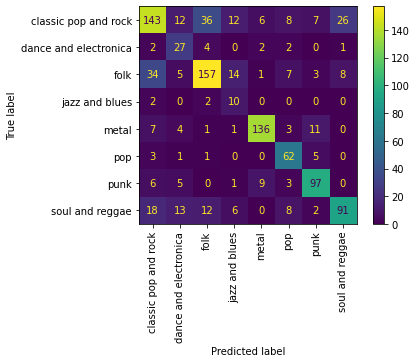

In [82]:
compute_metrics(y_val, y_pred)

# Full Pipeline Training

```json
{'objective': 'multiclass',
 'metric': 'multi_logloss',
 'verbosity': -1,
 'boosting_type': 'gbdt',
 'feature_pre_filter': False,
 'device': 'gpu',
 'num_class': 8,
 'lambda_l1': 0.09686860149587874,
 'lambda_l2': 2.317278758305513,
 'num_leaves': 97,
 'feature_fraction': 0.7408758758129015,
 'bagging_fraction': 0.6861197195062518,
 'bagging_freq': 7,
 'min_child_samples': 78}
```

In [90]:
X = preprocessing_pipeline.fit_transform(data)
y = label_encoder.transform(labels) 

In [91]:
d_Train = lgb.Dataset(X,y)

In [92]:
best_params = {'objective': 'multiclass',
 'metric': 'multi_logloss',
 'verbosity': -1,
 'boosting_type': 'gbdt',
 'feature_pre_filter': False,
 'num_class': 8,
 'lambda_l1': 0.09686860149587874,
 'lambda_l2': 2.317278758305513,
 'num_leaves': 97,
 'feature_fraction': 0.7408758758129015,
 'bagging_fraction': 0.6861197195062518,
 'bagging_freq': 7,
 'min_child_samples': 78}

In [93]:
final_model = lgb.train(best_params, d_Train, num_boost_round=lgb_model.best_iteration)

# Export Preprocess-Pipeline Model & Label Encoder

In [97]:
import joblib

In [98]:
joblib.dump(label_encoder, "label_encoder.bin")

['label_encoder.bin']

In [99]:
joblib.dump(preprocessing_pipeline, "preprocessing_pipeline.bin")

['preprocessing_pipeline.bin']

In [100]:
joblib.dump(lgb_model, "lgb_model.bin")

['lgb_model.bin']

In [101]:
joblib.dump(final_model, "final_model.bin")

['final_model.bin']